Let's take a look the basic process to fit a model in machine learning. We are going to assume that the data is already clean, 
since the purpose here is not perform exploratory data analysis but to create a model using scikit-learn framework.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## MODELS ##
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

## METRICS ##
# classificaton models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
# regression models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# in case you want silence warnings
#import warnings
#warnings.filterwarnings("ignore") #"default"

### Function Definitions

In [3]:
def print_performance_metrics_aprf(y_true, y_pred, average="binary"):
    """
    Combine the main classification metrics accuracy, precision, recall and f1 score.
    Parameters:
        y_true: the true value from the dataset
        y_pred: the precitions from the model
        avarage: used in case it is a multi-class classification
    """
    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
    print(f"Precision: {precision_score(y_true, y_pred, average=average)*100:.2f}%")
    print(f"Recall: {recall_score(y_true, y_pred, average=average)*100:.2f}%")
    print(f"F1 Score: {f1_score(y_true, y_pred, average=average)*100:.2f}%")

In [4]:
def plot_classification_metrics(y_true, y_pred, average="binary"):
    """
    Create a simple plot with all four classification metrics.
    Parameters:
        y_true: the true value from the dataset
        y_pred: the precitions from the model
        avarage: used in case it is a multi-class classification
    """
    metrics = [0,0,0,0]
    metrics[0] = accuracy_score(y_true, y_pred)
    metrics[1] = precision_score(y_true, y_pred, average=average)
    metrics[2] = recall_score(y_true, y_pred, average=average)
    metrics[3] = f1_score(y_true, y_pred, average=average)
    print(metrics)
    plt.bar(x=[0,1,2,3], height=metrics)
    plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
    plt.ylim([.6,1])
    plt.legend(['Metrics'])
    plt.title('Performance metrics')
    plt.show()

In [5]:
def get_metric_names(metric_list: list):
    """
    The function receives a list of substrings and it will return all metrics that contains the substrings.
    Parameters:
        metric_list (list): list with substrings of potential metric name.
    return:
        a list with all metrics that matches the substrings provided
    """
    from sklearn.metrics import SCORERS
    
    result = set()
    metrics = []
    for metric_substring in metric_list:
        metrics = [i for i in SCORERS if metric_substring in i]
        
        for m in metrics:
            result.add(m)
    
    return result

In [6]:
def split_scaling_features(X, y, scaler, test_size=0.2, random_state=None):
    """
    Function that splits the features into train and test, and in addition, performs feature scaling.
    Parameters:
        X: features from the dataset
        y: label from the dataset
        scaler: the type of feature scaling method applied. It can be 'min_max' for MinMaxScaler(), 'max_abs' for MaxAbsScaler(),
                and 'std' for StandardScaler().
    Return:
        X_train, X_test, y_train, y_test
    """
    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    if (scaler == "min_max"):
        scaler = MinMaxScaler()
    elif (scaler == "max_abs"):
        scaler = MaxAbsScaler()
    elif (scaler == "std"):
        scaler = StandardScaler()
    else:
        scaler = StandardScaler()
    
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

### Model training

In [7]:
df = pd.read_csv("heart-disease.csv")

In [8]:
df.head(4)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1


#### Step 1: Separate the features and the label

In [9]:
# This is a classification model to predict heart disease.
X = df.drop(columns="target")
y = df["target"]

X.shape, y.shape

((303, 13), (303,))

#### Step 2: Split the data into train and test. In addition, perform feature scaling.

Cross-validation is a generic term that indicates a methodology to split the data into train (to create the model) and test (to test the performance of the model). The basic methodology is to split into train and test. Another methodology is to split into train, evaluation (used to fine tuning the hyperparameters) and test (the truly unseen data used to perform the final test).

A variation of train/evaluation/test sets is to use cros_val_score() or cross_validate() function. cross_validate function returns more information and it allows to use compute more performance metrics. That's what we are going to do.

In [10]:
# let's use the function split_scaling_features, defined above, to perform train/test split and feature scaling
X_train, X_test, y_train, y_test = split_scaling_features(X, y, scaler="min_max", test_size=0.3, random_state=7)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212,), (91,))

Step 3: Choose the model based on the type of problem. In this case, this is a classificaiton problem, and we use random forest estimator.

In [12]:
model = RandomForestClassifier(n_estimators=100, max_features='sqrt')

In [13]:
# we use 5 folds (cv=5). The scoring parameters is the errors you want to measure. You need to pass the correct name. 
# Go to https://scikit-learn.org/stable/modules/model_evaluation.html for a complete list of metrics you can use.
# You can also use the funciton above get_metric_names() that returns the metrics from a substring of metrics

# I want metrics with contains error and root in their names. For this classification metrics. Let's see what it returns:
get_metric_names(["error", "root"])

{'max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error'}

In [14]:
scores_cv = cross_validate(model, X_train, y_train, scoring=["neg_mean_absolute_error","neg_root_mean_squared_error"], cv=5)
#OR 
#scores_cv = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)

In [15]:
scores_cv

{'fit_time': array([0.31000376, 0.3343792 , 0.31540275, 0.27798295, 0.31803226]),
 'score_time': array([0.02154946, 0.02779198, 0.01570535, 0.01727295, 0.02190852]),
 'test_neg_mean_absolute_error': array([-0.1627907 , -0.23255814, -0.07142857, -0.0952381 , -0.0952381 ]),
 'test_neg_root_mean_squared_error': array([-0.40347329, -0.48224282, -0.26726124, -0.3086067 , -0.3086067 ])}

In [16]:
pd.DataFrame(scores_cv)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
0,0.310004,0.021549,-0.162791,-0.403473
1,0.334379,0.027792,-0.232558,-0.482243
2,0.315403,0.015705,-0.071429,-0.267261
3,0.277983,0.017273,-0.095238,-0.308607
4,0.318032,0.021909,-0.095238,-0.308607


In [17]:
abs(pd.DataFrame(scores_cv).mean())

fit_time                            0.311160
score_time                          0.020846
test_neg_mean_absolute_error        0.131451
test_neg_root_mean_squared_error    0.354038
dtype: float64

In [18]:
# We can tuning the hyperparameters until we are satisfied with the performance.
# Now we need to fit to get the final model.
model.fit(X_train, y_train);

In [19]:
y_pred = model.predict(X_test)

In [20]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1], dtype=int64)

[0.7362637362637363, 0.7037037037037037, 0.8260869565217391, 0.76]


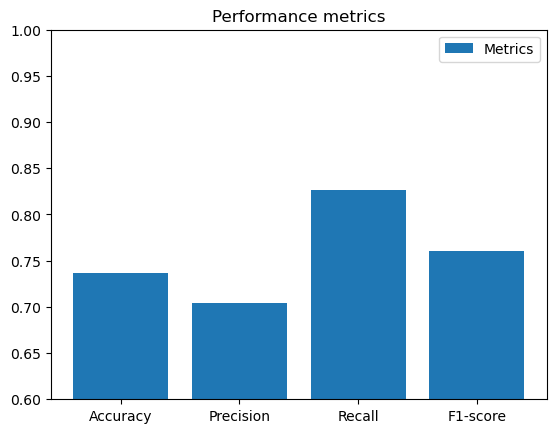

In [21]:
# function to disply the four main classification metrics
plot_classification_metrics(y_true=y_test, y_pred=y_pred)

In [22]:
print_performance_metrics_aprf(y_true=y_test, y_pred=y_pred)

Accuracy: 73.63%
Precision: 70.37%
Recall: 82.61%
F1 Score: 76.00%


Step 4: For completeness, we can use sklearn grid search function to adjust hyperparameters. With grid search we can test a model on many possilbe combination of hyperparameters.

In [23]:
# create a dictionary with the name of the hyperparameters we want to test.
grid_serach_parms = {"n_estimators": [64, 100, 128, 200],
                     "max_features": [3, 4, 5],
                     "bootstrap": [True, False]
    
}

In [24]:
model_grid = RandomForestClassifier()
# return the final model with the best parameters from the grid dictionary
grid_result = GridSearchCV(model_grid, grid_serach_parms)

In [25]:
grid_result.fit(X_train, y_train)
grid_result.best_params_

{'bootstrap': True, 'max_features': 3, 'n_estimators': 128}

In [26]:
y_pred_grid = grid_result.predict(X_test)

[0.7252747252747253, 0.6842105263157895, 0.8478260869565217, 0.7572815533980581]


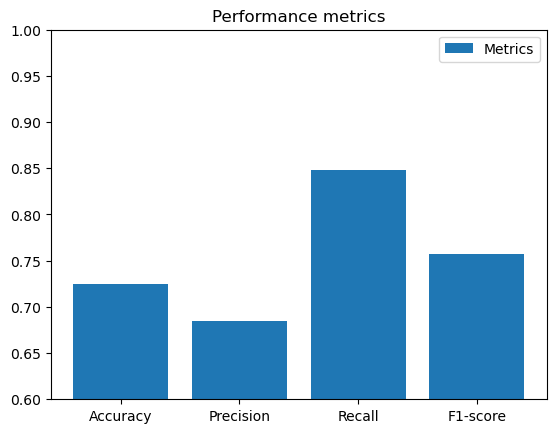

In [27]:
# function to disply the four main classification metrics
plot_classification_metrics(y_true=y_test, y_pred=y_pred_grid)

In [28]:
print_performance_metrics_aprf(y_true=y_test, y_pred=y_pred_grid)

Accuracy: 72.53%
Precision: 68.42%
Recall: 84.78%
F1 Score: 75.73%


Step 5: Save the model

In [29]:
from joblib import dump, load
dump(grid_result, 'heart_disease_model.joblib') 

['heart_disease_model.joblib']